<a href="https://colab.research.google.com/github/springtimeofyouth/Pneumonia_classification/blob/main/Pneumonia_detection_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we are importing directly from kaggle, since it is a large dataset.
Go to Kaggle and generate an api token. A .json file will downloaded. Upload it when you run the second cell.

Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
#install kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()
#Uncomment and run the 1st 2 lines

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdtoufik","key":"80769c58dda63706b43c534ae632eb35"}'}

In [3]:
#create a kaggle directory
! mkdir ~/.kaggle

In [4]:
#copy the json file to the folder created
! cp kaggle.json ~/.kaggle/

In [5]:
#Grant Permission
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# to list all the datasets in kaggle
! kaggle datasets list

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
carlmcbrideellis/llm-7-prompt-training-dataset                  LLM: 7 prompt training dataset                     41MB  2023-11-15 07:32:56            857         77  1.0              
thedrcat/daigt-proper-train-dataset                             DAIGT Proper Train Dataset                        119MB  2023-11-05 14:03:25            936        108  1.0              
iamsouravbanerjee/customer-shopping-trends-dataset              Customer Shopping Trends Dataset                  146KB  2023-10-05 06:45:37          30662        573  1.0              
joebeachcapital/30000-spotify-songs                             30000 

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:13<00:00, 231MB/s]
100% 2.29G/2.29G [00:14<00:00, 175MB/s]


In [8]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# What is Pneumonia ?
From Mayo Clinic's Article on pneumonia

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

![Pneumonia](https://img.freepik.com/free-vector/pneumonia-realistic-infographic_1284-59342.jpg?w=2000)

Symptoms :
* Chest pain when you breathe or cough
* Confusion or changes in mental awareness (in adults age 65 and older)
* Cough, which may produce phlegm
* Fatigue
* Fever, sweating and shaking chills
* Lower than normal body temperature (in adults older than age 65 and people with weak immune systems)
* Nausea, vomiting or diarrhea
* Shortness of breath




# Importing the necessary libraries

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

## Dataset description
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [10]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

## Loading the Dataset

In [11]:
train = get_data('chest_xray/chest_xray/train')
test = get_data('chest_xray/chest_xray/test')
val = get_data('chest_xray/chest_xray/val')

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-10-224b011a10db>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Data Visualization & Preprocessing

##### Let's check out the dataset we're working on by picking out two data points from the dataset.

In [12]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

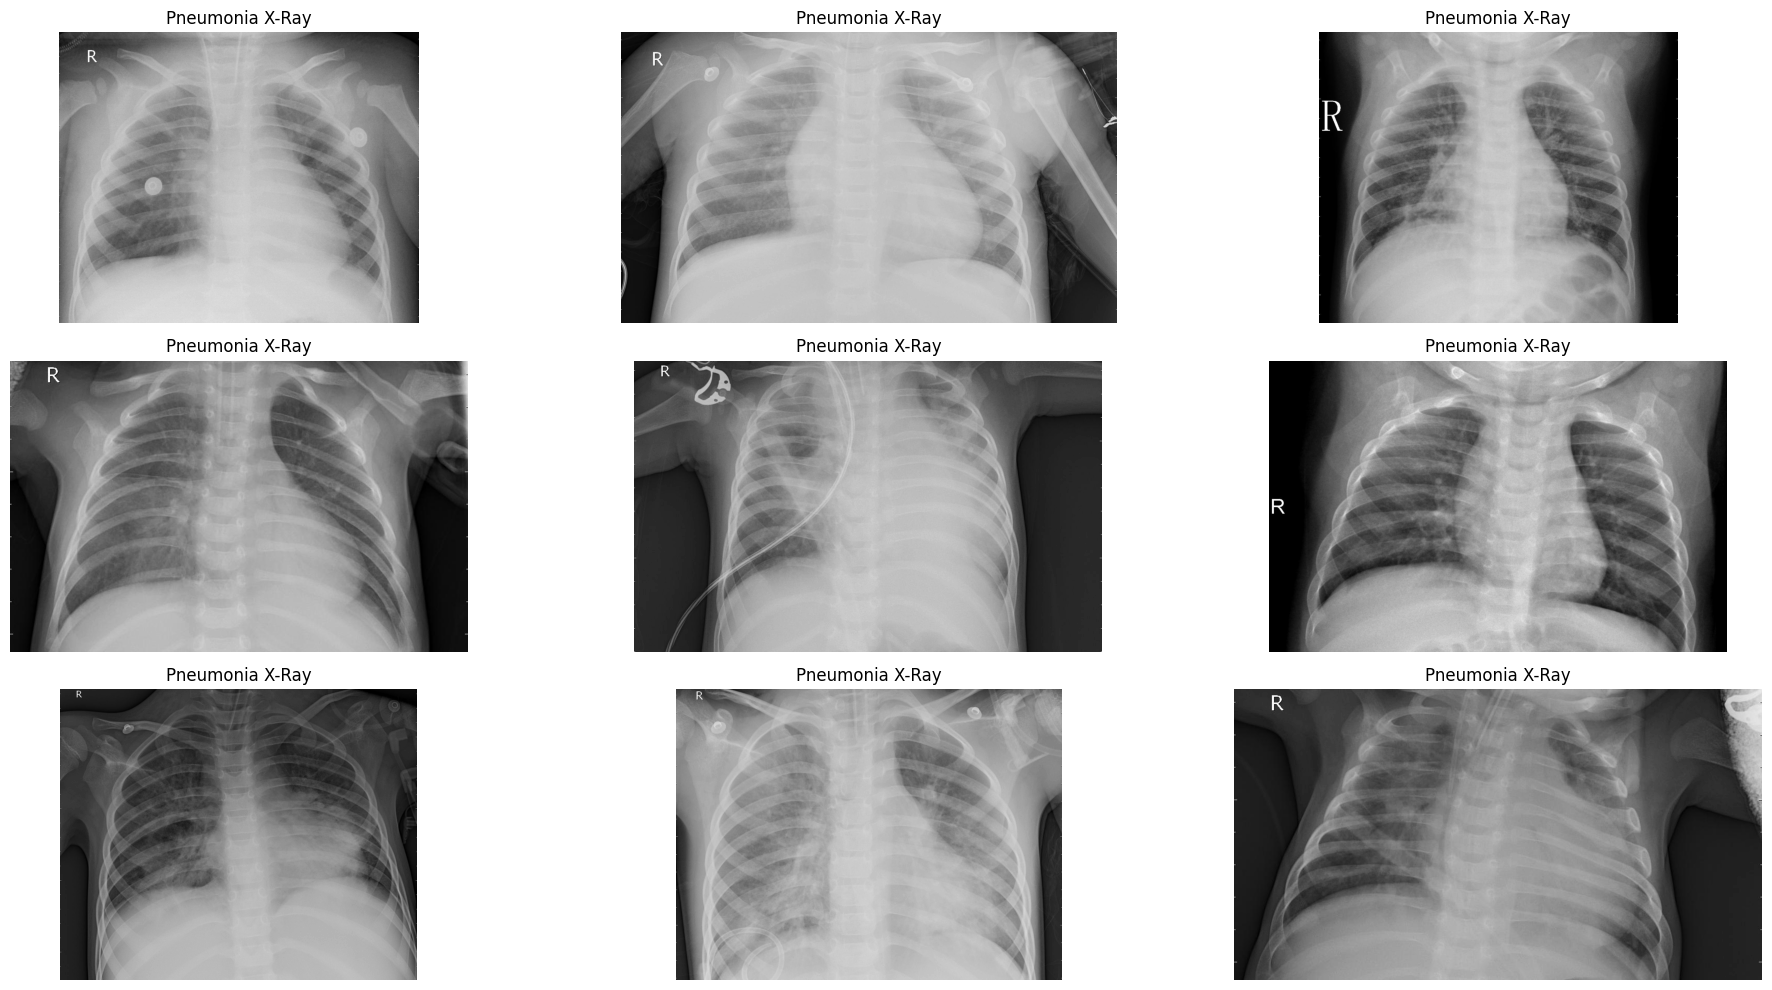

In [13]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray")
plt.tight_layout()

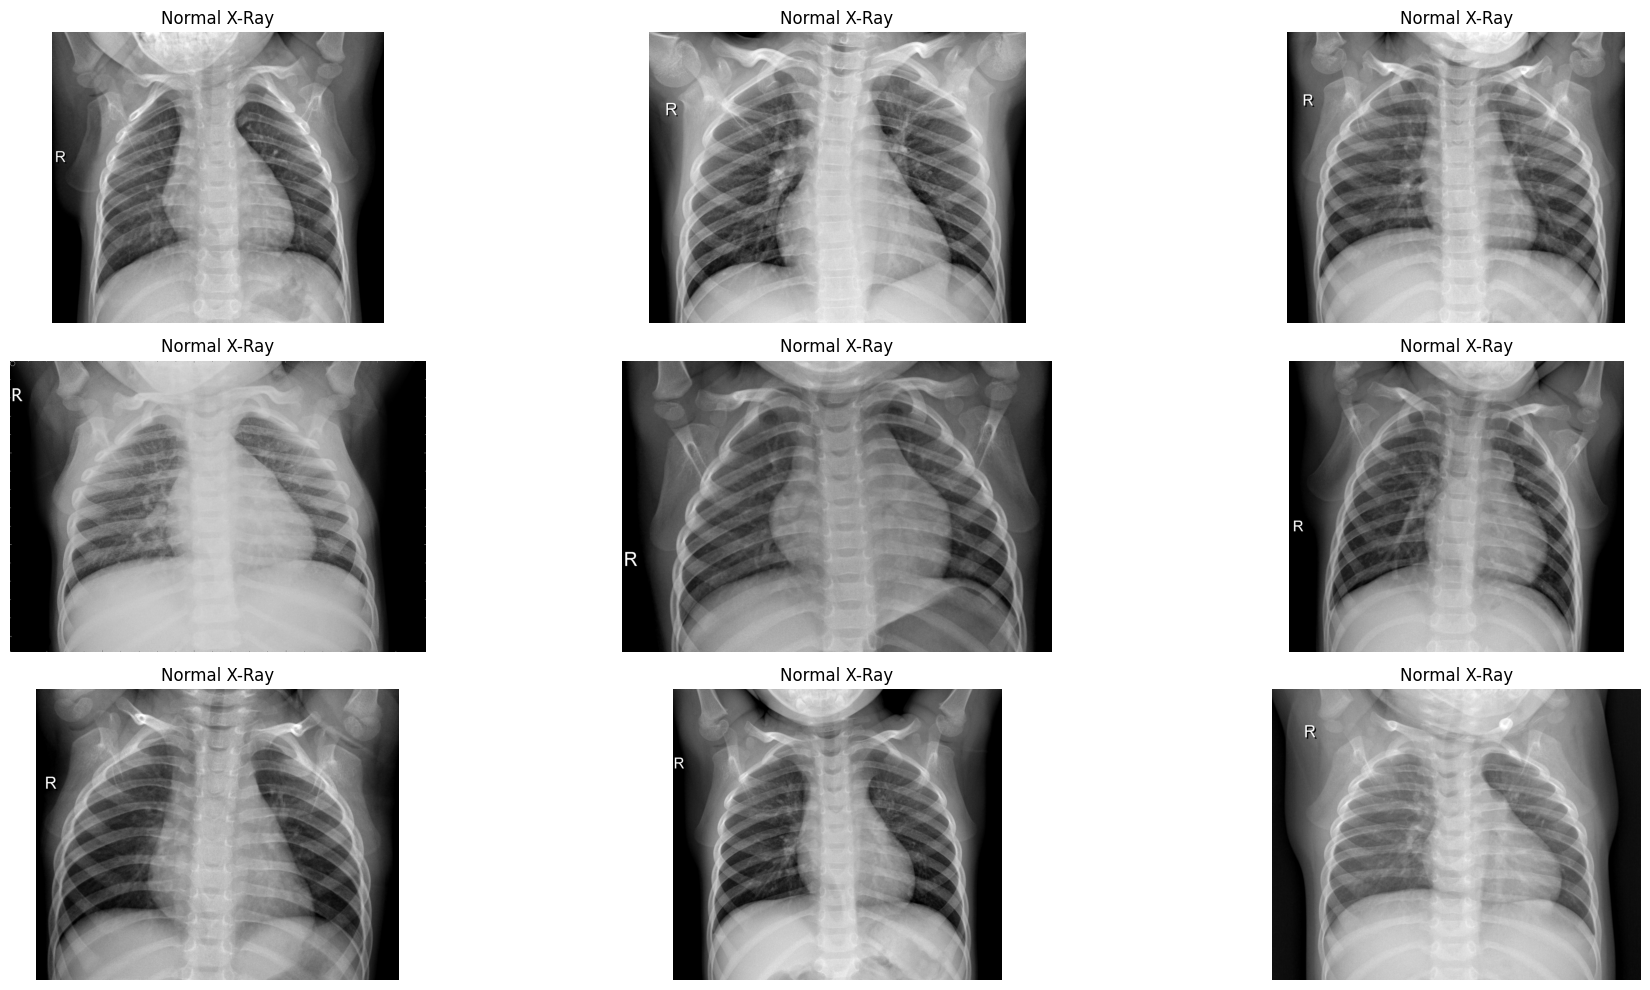

In [14]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray")

plt.tight_layout()

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-10-224b011a10db>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


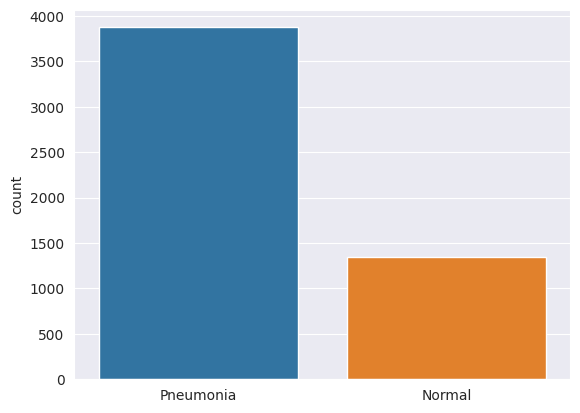

In [15]:
data = get_data('chest_xray/chest_xray/train')

# Creating the countplot
sns.set_style('darkgrid')
sns.countplot(x=data[:, 1])  # Assuming class labels are in the second column

# Adding labels to the plot
plt.xticks([0, 1], ["Pneumonia", "Normal"])

# Display the plot
plt.show()

##### **The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

# Previewing the images of both the classes

Text(0.5, 1.0, 'NORMAL')

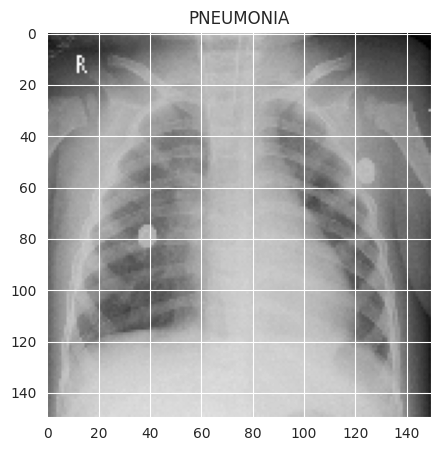

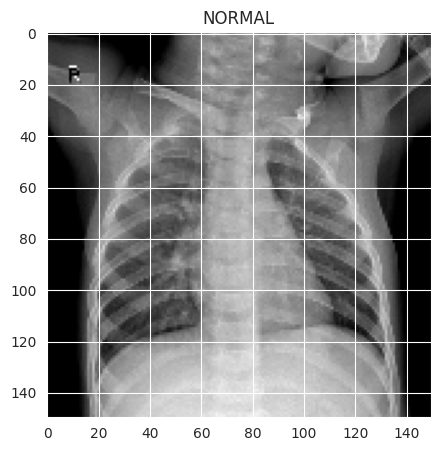

In [16]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

**Next, we perform some Data Preprocessing and Data Augmentation before we can proceed with building the model.**

In [17]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

## Normalizing the data

In [18]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

For the data augmentation, i choosed to :

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.

Once our model is ready, we fit the training dataset.

In [19]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training the Model

##### Basic Structure of CNN

![CNN_IMAGE](https://miro.medium.com/v2/resize:fit:1400/1*7S266Kq-UCExS25iX_I_AQ.png)

**SAME Padding: it applies padding to the input image so that the input image gets fully covered by the filter and specified stride.It is called SAME because, for stride 1 , the output will be the same as the input.**

![CNN_IMAGE2](https://production-media.paperswithcode.com/methods/MaxpoolSample2.png)

# ![CNN_IMAGE3](https://mriquestions.com/uploads/3/4/5/7/34572113/cnn-sample-layout_orig.png)


![Image-1](https://miro.medium.com/v2/resize:fit:678/1*-OM6jQTMNACDX2vAh_lvMQ.png)

In [20]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [22]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 29s 92ms/step - loss: 0.5146 - accuracy: 0.8355 - val_loss: 27.1657 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 15s 90ms/step - loss: 0.2849 - accuracy: 0.8990 - val_loss: 27.1172 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9133
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 20s 122ms/step - loss: 0.2296 - accuracy: 0.9133 - val_loss: 10.6202 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 28s 174ms/step - loss: 0.1490 - accuracy: 0.9471 - val_loss: 0.2584 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 15s 91ms/step - loss: 0.1427 - accuracy: 0.9536 - val_loss: 2.2294 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 6/12
163/163 [=====================

In [23]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 13ms/step - loss: 0.2927 - accuracy: 0.8782
Loss of the model is -  0.2926948070526123
20/20 [==============================] - 0s 12ms/step - loss: 0.2927 - accuracy: 0.8782
Accuracy of the model is -  87.82051205635071 %


# Analysis after Model Training

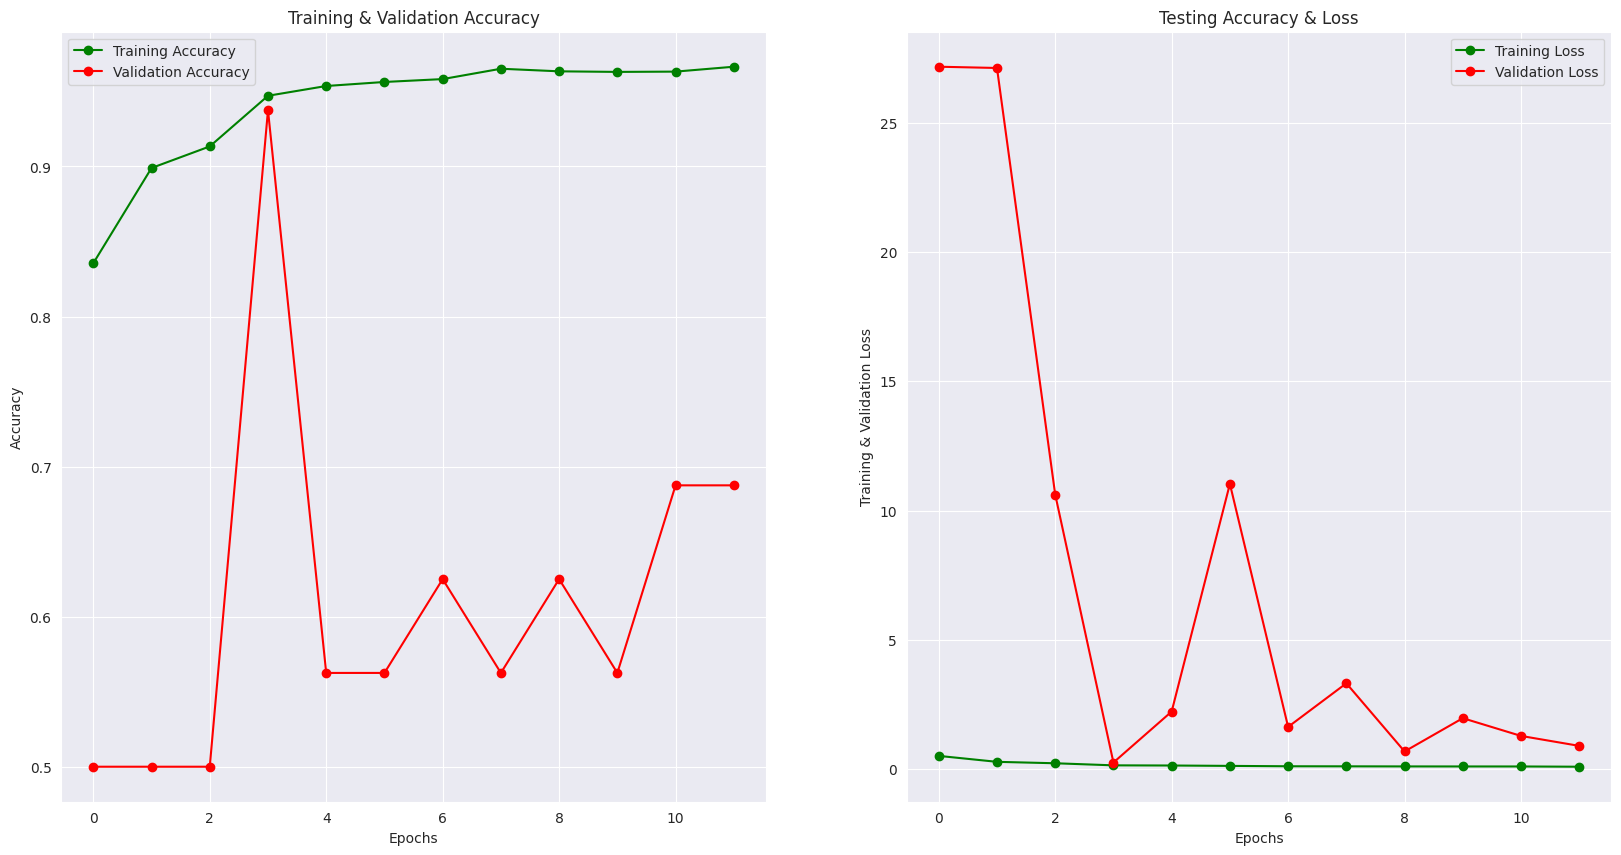

In [24]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

# Predictions

In [41]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 0s 10ms/step


array([8.9192623e-03, 4.1880976e-06, 2.6012111e-02, 9.6159682e-02,
       4.1200239e-02, 7.9512030e-01, 1.1660269e-01, 3.1236350e-04,
       7.8602163e-03, 1.1947711e-01, 1.6659421e-01, 2.1621223e-10,
       9.0222053e-02, 7.8124389e-02, 2.5774222e-02], dtype=float32)

In [42]:
binary_predictions = (predictions > 0.5).astype(int)
print(classification_report(y_test, binary_predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.86      0.90       390
   Normal (Class 1)       0.80      0.91      0.85       234

           accuracy                           0.88       624
          macro avg       0.87      0.88      0.87       624
       weighted avg       0.89      0.88      0.88       624



In [44]:
cm = confusion_matrix(y_test,binary_predictions)
cm

array([[336,  54],
       [ 22, 212]])

In [45]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

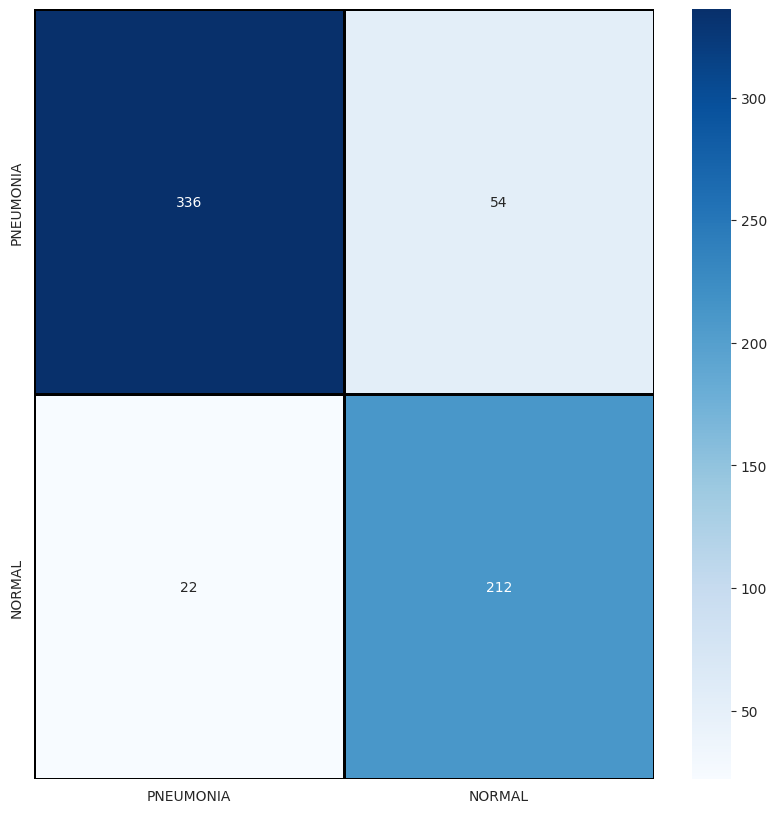

In [46]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [47]:
correct = np.nonzero(binary_predictions == y_test)[0]
incorrect = np.nonzero(binary_predictions != y_test)[0]

## Some of the Correctly Predicted Classes

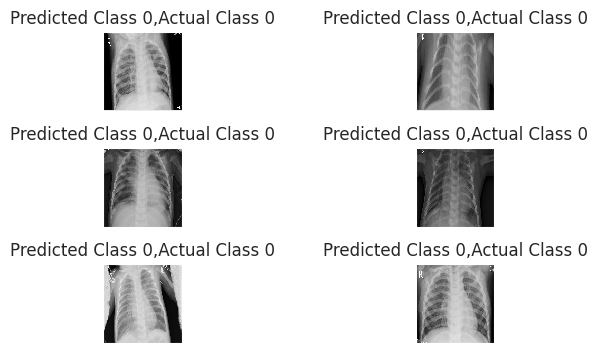

In [50]:
i = 0
for c in correct[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(binary_predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

## Some of the Incorrectly Predicted Classes

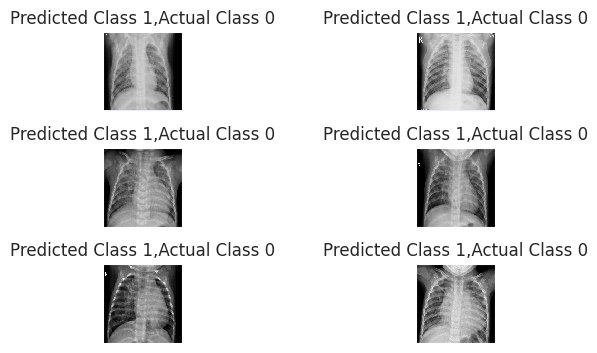

In [52]:
i = 0
for c in incorrect[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(binary_predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
#model.save(../model.h5)